<a href="https://colab.research.google.com/github/lacykaltgr/agriculture-image-processing/blob/SatiX/run_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from torch.nn import init

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=9,
                 hiddens=None, dropouts=None, kernel_sizes=None, maxpools=None, paddings=None, strides=None,
                 criterion=nn.CrossEntropyLoss(), activation=nn.ReLU(), output_activation=nn.Softmax(dim=1),
                 pre_process=None, post_process=None, dimensions=2, device='cuda'):
        super(UNet, self).__init__()

        if dimensions == 2:
            conv = nn.Conv2d
            batchnorm = nn.BatchNorm2d
            dropout = nn.Dropout2d
            maxpool = nn.MaxPool2d
        elif dimensions == 3:
            conv = nn.Conv3d
            batchnorm = nn.BatchNorm3d
            dropout = nn.Dropout3d
            maxpool = nn.MaxPool3d
        else:
            raise ValueError('Only 2D and 3D convolutions are supported')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.criterion = criterion
        self.pre_process = pre_process if pre_process is not None else lambda x: x
        self.post_process = post_process if post_process is not None else lambda x: x
        self.device = device

        # channels
        if hiddens is None:
            hiddens = [64]
        elif isinstance(hiddens, int):
            hiddens = [hiddens]
        elif isinstance(hiddens, list):
            assert len(hiddens) > 0, "Number of hiddens must be greater than 0"
        else:
            raise ValueError("Hiddens must be an integer or a list of integers")
        channels_downsample = [in_channels] + hiddens
        self.n_downsamples = len(channels_downsample) - 1
        channels_upsample = hiddens[::-1] + [out_channels]
        self.n_upsamples = len(channels_upsample) - 2

        # dropouts
        if dropouts is None:
            dropouts = [0] * self.n_downsamples
        elif isinstance(dropouts, float):
            dropouts = [dropouts] * self.n_downsamples
        elif isinstance(dropouts, list):
            assert len(dropouts) == self.n_downsamples, \
                "Number of dropouts must match the number of downsamples"
        else:
            raise ValueError("Dropouts must be a float or a list of floats")

        # maxpools
        if maxpools is None:
            maxpools = [2] * self.n_downsamples
        elif isinstance(maxpools, int):
            maxpools = [maxpools] * self.n_downsamples
        elif isinstance(maxpools, tuple):
            maxpools = [maxpools] * self.n_downsamples
        elif isinstance(maxpools, list):
            assert len(maxpools) == self.n_downsamples, \
                "Number of maxpools must match the number of downsamples"
        else:
            raise ValueError("Maxpools must be an integer, a tuple of integers or a list of integers")

        n_enc_convolutions = 2 * self.n_downsamples
        n_dec_convolutions = 3 * self.n_upsamples + 2
        # kernel_sizes
        if kernel_sizes is None:
            kernel_sizes = [[3] * n_enc_convolutions, [3] * n_dec_convolutions]
        elif isinstance(kernel_sizes, int):
            kernel_sizes = [[kernel_sizes] * n_enc_convolutions, [kernel_sizes] * n_dec_convolutions]
        elif isinstance(kernel_sizes, tuple):
            kernel_sizes = [[kernel_sizes] * n_enc_convolutions, [kernel_sizes] * n_dec_convolutions]
        elif isinstance(kernel_sizes, list):
            assert len(kernel_sizes) == 2, \
                "Number of kernel_sizes must be organized into encoder, decoder kernel sizes"
            assert len(kernel_sizes[0]) == n_enc_convolutions, \
                "Number of encoder kernel_sizes must match the number of encoder convolutions"
            assert len(kernel_sizes[1]) == n_dec_convolutions, \
                "Number of decoder kernel_sizes must match the number of decoder convolutions"
        else:
            raise ValueError("Kernel_sizes must be an integer, a tuple of integers or a list of integers")

        enc_kernel_sizes, dec_kernel_sizes = kernel_sizes

        if paddings is None:
            paddings = [['same'] * n_enc_convolutions, ['same'] * n_dec_convolutions]
        elif isinstance(paddings, str):
            paddings = [[paddings] * n_enc_convolutions, [paddings] * n_dec_convolutions]
        elif isinstance(paddings, tuple):
            paddings = [[paddings] * n_enc_convolutions, [paddings] * n_dec_convolutions]
        elif isinstance(paddings, int):
            paddings = [[paddings] * n_enc_convolutions, [paddings] * n_dec_convolutions]
        elif isinstance(paddings, list):
            assert len(paddings) == 2, \
                "Number of paddings must be organized into encoder, decoder paddings"
            assert len(paddings[0]) == n_enc_convolutions, \
                "Number of encoder paddings must match the number of encoder convolutions"
            assert len(paddings[1]) == n_dec_convolutions, \
                "Number of decoder paddings must match the number of decoder convolutions"
        else:
            raise ValueError("Paddings must be an integer, a tuple of integers or a list of integers")
        enc_paddings, dec_paddings = paddings

        if strides is None:
            strides = [[1] * n_enc_convolutions, [1] * n_dec_convolutions]
        elif isinstance(strides, int):
            strides = [[strides] * n_enc_convolutions, [strides] * n_dec_convolutions]
        elif isinstance(strides, tuple):
            strides = [[strides] * n_enc_convolutions, [strides] * n_dec_convolutions]
        elif isinstance(strides, list):
            assert len(strides) == 2, \
                "Number of strides must be organized into encoder, decoder strides"
            assert len(strides[0]) == n_enc_convolutions, \
                "Number of encoder strides must match the number of encoder convolutions"
            assert len(strides[1]) == n_dec_convolutions, \
                "Number of decoder strides must match the number of decoder convolutions"
        else:
            raise ValueError("Strides must be an integer, a tuple of integers or a list of integers")
        enc_strides, dec_strides = strides

        self.layers_upsample = nn.ModuleDict()
        self.layers_downsample = nn.ModuleDict()

        # Left side of the U-Net
        for i in range(self.n_downsamples):
            self.layers_downsample[f"conv_enc_{i}_1"] = \
                conv(channels_downsample[i], channels_downsample[i + 1],
                     kernel_size=enc_kernel_sizes[2 * i], padding=enc_paddings[2 * i], stride=enc_strides[2 * i])

            self.layers_downsample[f"conv_enc_{i}_2"] = \
                conv(channels_downsample[i + 1], channels_downsample[i + 1],
                     kernel_size=enc_kernel_sizes[2 * i + 1], padding=enc_paddings[2 * i + 1],
                     stride=enc_strides[2 * i + 1])

            self.layers_downsample[f"batchnorm_enc_{i}"] = \
                batchnorm(channels_downsample[i + 1])

            self.layers_downsample[f"dropout_{i}"] = \
                dropout(p=dropouts[i])

            if i != self.n_downsamples - 1:  # utsonak nem kell
                self.layers_downsample[f"maxpool_{i}"] = maxpool(maxpools[i])

        # Up-sampling starts, right side of the U-Net
        for i in range(self.n_upsamples):
            self.layers_upsample[f"upconv_dec_{i}"] = \
                conv(channels_upsample[i], channels_upsample[i + 1],
                     kernel_size=dec_kernel_sizes[3 * i], padding=dec_paddings[3 * i], stride=dec_strides[3 * i])

            self.layers_upsample[f"conv_dec_{i}_1"] = \
                conv(channels_upsample[i], channels_upsample[i + 1],
                     kernel_size=dec_kernel_sizes[3 * i + 1], padding=dec_paddings[3 * i + 1],
                     stride=dec_strides[3 * i + 1])

            self.layers_upsample[f"conv_dec_{i}_2"] = \
                conv(channels_upsample[i + 1], channels_upsample[i + 1],
                     kernel_size=dec_kernel_sizes[3 * i + 2], padding=dec_paddings[3 * i + 2],
                     stride=dec_strides[3 * i + 2])

            if i == self.n_upsamples - 1:
                self.layers_upsample[f"conv_dec_{i}_3"] = \
                    conv(channels_upsample[i + 1], channels_upsample[i + 1],
                         kernel_size=dec_kernel_sizes[3 * i + 3], padding=dec_paddings[3 * i + 3],
                         stride=dec_strides[3 * i + 3])
            self.layers_upsample[f"batchnorm_dec_{i}"] = batchnorm(channels_upsample[i + 1])
            #else:
            #    self.layers_upsample[f"batchnorm_dec_{i}"] = batchnorm(channels_upsample[i + 1])

        # Output layer of the U-Net with a softmax activation
        self.layers_upsample["conv_out"] = \
            conv(channels_upsample[-2], channels_upsample[-1],
                 kernel_size=dec_kernel_sizes[-1], padding=dec_paddings[-1], stride=dec_strides[-1])
        self.output_activation = output_activation
        self.activation = activation

        # initialize all parameters with xavier uniform
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        skip_connections = []
        # Left side of the U-Net
        for i in range(self.n_downsamples):
            x = self.activation(self.layers_downsample[f"conv_enc_{i}_1"](x))
            x = self.activation(self.layers_downsample[f"conv_enc_{i}_2"](x))
            x = self.layers_downsample[f"batchnorm_enc_{i}"](x)
            x = self.layers_downsample[f"dropout_{i}"](x)

            if i != self.n_downsamples - 1:
                skip_connections.append(x)
                x = self.layers_downsample[f"maxpool_{i}"](x)

        # Upsampling Starts, right side of the U-Net
        for i in range(self.n_upsamples):
            skip = skip_connections.pop()
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
            x = self.activation(self.layers_upsample[f"upconv_dec_{i}"](x))
            x = torch.cat([skip, x], dim=1)
            x = self.activation(self.layers_upsample[f"conv_dec_{i}_1"](x))
            x = self.activation(self.layers_upsample[f"conv_dec_{i}_2"](x))

            if i == self.n_upsamples - 1:
                x = self.activation(self.layers_upsample[f"conv_dec_{i}_3"](x))
            x = self.layers_upsample[f"batchnorm_dec_{i}"](x)

        # Output layer of the U-Net with a softmax activation
        out_conv = self.layers_upsample["conv_out"](x)
        y = self.output_activation(out_conv)
        return y

    def train_model(self, train_loader, valid_loader, early_stopper,
                    num_epochs=100, learning_rate=1e-4, weight_decay=1e-5, device='cuda'):
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train_loss = valid_loss = []
        for epoch in range(num_epochs):
            epoch_train_loss = correct_train = total_train = 0
            self.train()
            for batch in train_loader:
                optimizer.zero_grad()
                inputs, targets = batch
                inputs, targets = inputs.to(device).float(), targets.to(device).float()
                outputs = self(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

                c, t = self._accuracy_score(targets, outputs)
                correct_train += c
                total_train += t

                outputs.detach().cpu()
                targets.detach().cpu()

            train_accuracy = 100 * correct_train / total_train

            epoch_valid_loss, valid_accuracy = self.evaluate(valid_loader, device=device)

            epoch_train_loss /= len(train_loader)
            epoch_valid_loss /= len(valid_loader)
            train_loss.append(epoch_train_loss)
            valid_loss.append(epoch_valid_loss)
            print(
                f'Epoch {epoch + 1:03}: | Train Loss: {epoch_train_loss:.5f} | Validation Loss: {epoch_valid_loss:.5f}'
                + f' | Train Acc: {train_accuracy:.2f}% | Valid Acc: {valid_accuracy:.2f}%')

            if early_stopper.early_stop(epoch_valid_loss):
                break
        return train_loss, valid_loss

    def predict(self, test_loader, device='cuda'):
        self.eval()
        raw_predictions = []
        with torch.no_grad():
            for batch in test_loader:
                inputs, _ = batch
                inputs = self.pre_process(inputs).to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                raw_predictions.append(preds.detach().cpu().numpy())
        results = []
        for batch in raw_predictions:
            for img in batch:
                results.append(self.post_process(img))
        return results, raw_predictions

    def evaluate(self, test_loader, device='cuda'):
        epoch_valid_loss = 0
        self.eval()
        correct_valid = 0
        total_valid = 0
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()
            outputs = self(inputs)
            loss = self.criterion(outputs, targets)
            epoch_valid_loss += loss.item()

            c, t = self._accuracy_score(targets, outputs)
            correct_valid += c
            total_valid += t

            outputs.detach().cpu()
            targets.detach().cpu()

        valid_accuracy = 100 * correct_valid / total_valid
        return epoch_valid_loss, valid_accuracy

    def summary(self, input_shape):
        from torchinfo import summary
        return summary(self, input_size=input_shape)

    @staticmethod
    def _accuracy_score(y_true, y_pred):
        if y_true.shape[1] == 1:
            total = np.prod(y_true.size())
            correct = torch.sum(y_pred.round() == y_true).item()
            return correct, total
        else:
            _, acc_predictions = torch.max(y_pred, 1)
            _, acc_targets = torch.max(y_true, 1)
            total = np.prod(acc_targets.size())
            correct = (acc_predictions == acc_targets).sum().item()
            return correct, total




class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [2]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch

for i in range(torch.cuda.device_count()):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")



class _GridAttentionBlockND(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=3, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(_GridAttentionBlockND, self).__init__()

        assert dimension in [2, 3]
        assert mode in ['concatenation', 'concatenation_debug', 'concatenation_residual']

        # Downsampling rate for the input featuremap
        if isinstance(sub_sample_factor, tuple): self.sub_sample_factor = sub_sample_factor
        elif isinstance(sub_sample_factor, list): self.sub_sample_factor = tuple(sub_sample_factor)
        else: self.sub_sample_factor = tuple([sub_sample_factor]) * dimension

        # Default parameter set
        self.mode = mode
        self.dimension = dimension
        self.sub_sample_kernel_size = self.sub_sample_factor

        # Number of channels (pixel dimensions)
        self.in_channels = in_channels
        self.gating_channels = gating_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'trilinear'
        elif dimension == 2:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'bilinear'
        else:
            raise NotImplemented

        # Output transform
        self.W = nn.Sequential(
            conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
            bn(self.in_channels),
        )

        # Theta^T * x_ij + Phi^T * gating_signal + bias
        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)
        self.phi = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0, bias=True)
        self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        # Initialise weights
        for m in self.children():
            weights_init_kaiming(m)

        # Define the operation
        if mode == 'concatenation':
            self.operation_function = self._concatenation
        elif mode == 'concatenation_debug':
            self.operation_function = self._concatenation_debug
        elif mode == 'concatenation_residual':
            self.operation_function = self._concatenation_residual
        else:
            raise NotImplementedError('Unknown operation function.')


    def forward(self, x, g):
        '''
        :param x: (b, c, t, h, w)
        :param g: (b, g_d)
        :return:
        '''

        output = self.operation_function(x, g)
        return output

    def _concatenation(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.relu(theta_x + phi_g, inplace=True)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        sigm_psi_f = F.sigmoid(self.psi(f))

        # upsample the attentions and multiply
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f

    def _concatenation_debug(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.softplus(theta_x + phi_g)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        sigm_psi_f = F.sigmoid(self.psi(f))

        # upsample the attentions and multiply
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f


    def _concatenation_residual(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.relu(theta_x + phi_g, inplace=True)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        f = self.psi(f).view(batch_size, 1, -1)
        sigm_psi_f = F.softmax(f, dim=2).view(batch_size, 1, *theta_x.size()[2:])

        # upsample the attentions and multiply
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f


class GridAttentionBlock2D(_GridAttentionBlockND):
    def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(GridAttentionBlock2D, self).__init__(in_channels,
                                                   inter_channels=inter_channels,
                                                   gating_channels=gating_channels,
                                                   dimension=2, mode=mode,
                                                   sub_sample_factor=sub_sample_factor,
                                                   )


class MultiAttentionBlock(nn.Module):
    def __init__(self, in_size, gate_size, inter_size, nonlocal_mode, sub_sample_factor):
        super(MultiAttentionBlock, self).__init__()
        self.gate_block_1 = GridAttentionBlock2D(in_channels=in_size, gating_channels=gate_size,
                                                 inter_channels=inter_size, mode=nonlocal_mode,
                                                 sub_sample_factor= sub_sample_factor)
        self.combine_gates = nn.Sequential(nn.Conv2d(in_size, in_size, kernel_size=1, stride=1, padding=0),
                                           nn.BatchNorm2d(in_size),
                                           nn.ReLU(inplace=True)
                                           )

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('GridAttentionBlock2D') != -1: continue
            weights_init_kaiming(m)

    def forward(self, input, gating_signal):
        gate_1, attention_1 = self.gate_block_1(input, gating_signal)

        return self.combine_gates(gate_1), attention_1


class UnetGridGatingSignal3(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=(1,1,1), is_batchnorm=True):
        super(UnetGridGatingSignal3, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size, (1,1), (0,0)),
                                       nn.BatchNorm2d(out_size),
                                       nn.ReLU(inplace=True),
                                       )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size, (1,1), (0,0)),
                                       nn.ReLU(inplace=True),
                                       )

        # initialise the blocks
        for m in self.children():
            weights_init_kaiming(m)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        return outputs


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=9,
                 hiddens=None, dropouts=None, kernel_sizes=None, maxpools=None, paddings=None, strides=None,
                 criterion=nn.CrossEntropyLoss(), activation=nn.ReLU(), output_activation=nn.Softmax(dim=1),
                 pre_process=None, post_process=None, dimensions=2, device='cuda'):
        super(UNet, self).__init__()

        if dimensions == 2:
            conv = nn.Conv2d
            batchnorm = nn.BatchNorm2d
            dropout = nn.Dropout2d
            maxpool = nn.MaxPool2d
        elif dimensions == 3:
            conv = nn.Conv3d
            batchnorm = nn.BatchNorm3d
            dropout = nn.Dropout3d
            maxpool = nn.MaxPool3d
        else:
            raise ValueError('Only 2D and 3D convolutions are supported')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.criterion = criterion
        self.pre_process = pre_process if pre_process is not None else lambda x: x
        self.post_process = post_process if post_process is not None else lambda x: x
        self.device = device

        # channels
        if hiddens is None:
            hiddens = [64]
        elif isinstance(hiddens, int):
            hiddens = [hiddens]
        elif isinstance(hiddens, list):
            assert len(hiddens) > 0, "Number of hiddens must be greater than 0"
        else:
            raise ValueError("Hiddens must be an integer or a list of integers")
        channels_downsample = [in_channels] + hiddens
        self.n_downsamples = len(channels_downsample) - 1
        channels_upsample = hiddens[::-1] + [out_channels]
        self.n_upsamples = len(channels_upsample) - 2

        # dropouts
        if dropouts is None:
            dropouts = [0] * self.n_downsamples
        elif isinstance(dropouts, float):
            dropouts = [dropouts] * self.n_downsamples
        elif isinstance(dropouts, list):
            assert len(dropouts) == self.n_downsamples, \
                "Number of dropouts must match the number of downsamples"
        else:
            raise ValueError("Dropouts must be a float or a list of floats")

        # maxpools
        if maxpools is None:
            maxpools = [2] * self.n_downsamples
        elif isinstance(maxpools, int):
            maxpools = [maxpools] * self.n_downsamples
        elif isinstance(maxpools, tuple):
            maxpools = [maxpools] * self.n_downsamples
        elif isinstance(maxpools, list):
            assert len(maxpools) == self.n_downsamples, \
                "Number of maxpools must match the number of downsamples"
        else:
            raise ValueError("Maxpools must be an integer, a tuple of integers or a list of integers")

        n_enc_convolutions = 2 * self.n_downsamples
        n_dec_convolutions = 3 * self.n_upsamples + 2
        # kernel_sizes
        if kernel_sizes is None:
            kernel_sizes = [[3] * n_enc_convolutions, [3] * n_dec_convolutions]
        elif isinstance(kernel_sizes, int):
            kernel_sizes = [[kernel_sizes] * n_enc_convolutions, [kernel_sizes] * n_dec_convolutions]
        elif isinstance(kernel_sizes, tuple):
            kernel_sizes = [[kernel_sizes] * n_enc_convolutions, [kernel_sizes] * n_dec_convolutions]
        elif isinstance(kernel_sizes, list):
            assert len(kernel_sizes) == 2, \
                "Number of kernel_sizes must be organized into encoder, decoder kernel sizes"
            assert len(kernel_sizes[0]) == n_enc_convolutions, \
                "Number of encoder kernel_sizes must match the number of encoder convolutions"
            assert len(kernel_sizes[1]) == n_dec_convolutions, \
                "Number of decoder kernel_sizes must match the number of decoder convolutions"
        else:
            raise ValueError("Kernel_sizes must be an integer, a tuple of integers or a list of integers")

        enc_kernel_sizes, dec_kernel_sizes = kernel_sizes

        if paddings is None:
            paddings = [['same'] * n_enc_convolutions, ['same'] * n_dec_convolutions]
        elif isinstance(paddings, str):
            paddings = [[paddings] * n_enc_convolutions, [paddings] * n_dec_convolutions]
        elif isinstance(paddings, tuple):
            paddings = [[paddings] * n_enc_convolutions, [paddings] * n_dec_convolutions]
        elif isinstance(paddings, int):
            paddings = [[paddings] * n_enc_convolutions, [paddings] * n_dec_convolutions]
        elif isinstance(paddings, list):
            assert len(paddings) == 2, \
                "Number of paddings must be organized into encoder, decoder paddings"
            assert len(paddings[0]) == n_enc_convolutions, \
                "Number of encoder paddings must match the number of encoder convolutions"
            assert len(paddings[1]) == n_dec_convolutions, \
                "Number of decoder paddings must match the number of decoder convolutions"
        else:
            raise ValueError("Paddings must be an integer, a tuple of integers or a list of integers")
        enc_paddings, dec_paddings = paddings

        if strides is None:
            strides = [[1] * n_enc_convolutions, [1] * n_dec_convolutions]
        elif isinstance(strides, int):
            strides = [[strides] * n_enc_convolutions, [strides] * n_dec_convolutions]
        elif isinstance(strides, tuple):
            strides = [[strides] * n_enc_convolutions, [strides] * n_dec_convolutions]
        elif isinstance(strides, list):
            assert len(strides) == 2, \
                "Number of strides must be organized into encoder, decoder strides"
            assert len(strides[0]) == n_enc_convolutions, \
                "Number of encoder strides must match the number of encoder convolutions"
            assert len(strides[1]) == n_dec_convolutions, \
                "Number of decoder strides must match the number of decoder convolutions"
        else:
            raise ValueError("Strides must be an integer, a tuple of integers or a list of integers")
        enc_strides, dec_strides = strides

        self.layers_upsample = nn.ModuleDict()
        self.layers_downsample = nn.ModuleDict()
        self.attention = nn.ModuleDict()

        # Left side of the U-Net
        for i in range(self.n_downsamples):
            self.layers_downsample[f"conv_enc_{i}_1"] = \
                conv(channels_downsample[i], channels_downsample[i + 1],
                     kernel_size=enc_kernel_sizes[2 * i], padding=enc_paddings[2 * i], stride=enc_strides[2 * i])

            self.layers_downsample[f"conv_enc_{i}_2"] = \
                conv(channels_downsample[i + 1], channels_downsample[i + 1],
                     kernel_size=enc_kernel_sizes[2 * i + 1], padding=enc_paddings[2 * i + 1],
                     stride=enc_strides[2 * i + 1])

            self.layers_downsample[f"batchnorm_enc_{i}"] = \
                batchnorm(channels_downsample[i + 1])

            self.layers_downsample[f"dropout_{i}"] = \
                dropout(p=dropouts[i])

            if i != self.n_downsamples - 1:  # utsonak nem kell
                self.layers_downsample[f"maxpool_{i}"] = maxpool(maxpools[i])

        self.gating = UnetGridGatingSignal3(
            channels_downsample[-1], channels_upsample[0], kernel_size=(1, 1), is_batchnorm=True,
        )

        # Up-sampling starts, right side of the U-Net
        for i in range(self.n_upsamples):

            self.attention[f"attention_{i}"] = \
                MultiAttentionBlock(
                    channels_upsample[i+1], channels_upsample[i], channels_upsample[i+1], nonlocal_mode='concatenation', sub_sample_factor=(2, 2)
                )

            self.layers_upsample[f"upconv_dec_{i}"] = \
                conv(channels_upsample[i], channels_upsample[i + 1],
                     kernel_size=dec_kernel_sizes[3 * i], padding=dec_paddings[3 * i], stride=dec_strides[3 * i])

            self.layers_upsample[f"conv_dec_{i}_1"] = \
                conv(channels_upsample[i], channels_upsample[i + 1],
                     kernel_size=dec_kernel_sizes[3 * i + 1], padding=dec_paddings[3 * i + 1],
                     stride=dec_strides[3 * i + 1])

            self.layers_upsample[f"conv_dec_{i}_2"] = \
                conv(channels_upsample[i + 1], channels_upsample[i + 1],
                     kernel_size=dec_kernel_sizes[3 * i + 2], padding=dec_paddings[3 * i + 2],
                     stride=dec_strides[3 * i + 2])

            if i == self.n_upsamples - 1:
                self.layers_upsample[f"conv_dec_{i}_3"] = \
                    conv(channels_upsample[i + 1], channels_upsample[i + 1],
                         kernel_size=dec_kernel_sizes[3 * i + 3], padding=dec_paddings[3 * i + 3],
                         stride=dec_strides[3 * i + 3])
            self.layers_upsample[f"batchnorm_dec_{i}"] = batchnorm(channels_upsample[i + 1])
            #else:
            #    self.layers_upsample[f"batchnorm_dec_{i}"] = batchnorm(channels_upsample[i + 1])

        # Output layer of the U-Net with a softmax activation
        self.layers_upsample["conv_out"] = \
            conv(channels_upsample[-2], channels_upsample[-1],
                 kernel_size=dec_kernel_sizes[-1], padding=dec_paddings[-1], stride=dec_strides[-1])
        self.output_activation = output_activation
        self.activation = activation

        # initialize all parameters with xavier uniform
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        skip_connections = []
        # Left side of the U-Net
        for i in range(self.n_downsamples):
            x = self.activation(self.layers_downsample[f"conv_enc_{i}_1"](x))
            x = self.activation(self.layers_downsample[f"conv_enc_{i}_2"](x))
            x = self.layers_downsample[f"batchnorm_enc_{i}"](x)
            x = self.layers_downsample[f"dropout_{i}"](x)

            if i != self.n_downsamples - 1:
                skip_connections.append(x)
                x = self.layers_downsample[f"maxpool_{i}"](x)

        gating = self.gating(x)

        # Upsampling Starts, right side of the U-Net
        for i in range(self.n_upsamples):
            skip = skip_connections.pop()
            gate, _ = self.attention[f"attention_{i}"](skip, gating)

            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
            x = self.activation(self.layers_upsample[f"upconv_dec_{i}"](x))

            x = torch.cat([gate, x], dim=1)

            x = self.activation(self.layers_upsample[f"conv_dec_{i}_1"](x))
            x = self.activation(self.layers_upsample[f"conv_dec_{i}_2"](x))

            gating = x

            if i == self.n_upsamples - 1:
                x = self.activation(self.layers_upsample[f"conv_dec_{i}_3"](x))
            x = self.layers_upsample[f"batchnorm_dec_{i}"](x)

        # Output layer of the U-Net with a softmax activation
        out_conv = self.layers_upsample["conv_out"](x)
        y = self.output_activation(out_conv)
        return y

    def train_model(self, train_loader, valid_loader, early_stopper,
                    num_epochs=100, learning_rate=1e-4, weight_decay=1e-5, device='cuda'):
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train_loss = valid_loss = []
        for epoch in range(num_epochs):
            epoch_train_loss = correct_train = total_train = 0
            self.train()
            for batch in train_loader:
                optimizer.zero_grad()
                inputs, targets = batch
                inputs, targets = inputs.to(device).float(), targets.to(device).float()
                outputs = self(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

                c, t = self._accuracy_score(targets, outputs)
                correct_train += c
                total_train += t

                outputs.detach().cpu()
                targets.detach().cpu()

            train_accuracy = 100 * correct_train / total_train

            epoch_valid_loss, valid_accuracy = self.evaluate(valid_loader, device=device)

            epoch_train_loss /= len(train_loader)
            epoch_valid_loss /= len(valid_loader)
            train_loss.append(epoch_train_loss)
            valid_loss.append(epoch_valid_loss)
            print(
                f'Epoch {epoch + 1:03}: | Train Loss: {epoch_train_loss:.5f} | Validation Loss: {epoch_valid_loss:.5f}'
                + f' | Train Acc: {train_accuracy:.2f}% | Valid Acc: {valid_accuracy:.2f}%')

            if early_stopper.early_stop(epoch_valid_loss):
                break
        return train_loss, valid_loss

    def predict(self, test_loader, device='cuda'):
        self.eval()
        raw_predictions = []
        with torch.no_grad():
            for batch in test_loader:
                inputs, _ = batch
                inputs = self.pre_process(inputs).to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                raw_predictions.append(preds.detach().cpu().numpy())
        results = []
        for batch in raw_predictions:
            for img in batch:
                results.append(self.post_process(img))
        return results, raw_predictions

    def evaluate(self, test_loader, device='cuda'):
        epoch_valid_loss = 0
        self.eval()
        correct_valid = 0
        total_valid = 0
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()
            outputs = self(inputs)
            loss = self.criterion(outputs, targets)
            epoch_valid_loss += loss.item()

            c, t = self._accuracy_score(targets, outputs)
            correct_valid += c
            total_valid += t

            outputs.detach().cpu()
            targets.detach().cpu()

        valid_accuracy = 100 * correct_valid / total_valid
        return epoch_valid_loss, valid_accuracy

    def summary(self, input_shape):
        from torchinfo import summary
        return summary(self, input_size=input_shape)

    @staticmethod
    def _accuracy_score(y_true, y_pred):
        if y_true.shape[1] == 1:
            total = np.prod(y_true.size())
            correct = torch.sum(y_pred.round() == y_true).item()
            return correct, total
        else:
            _, acc_predictions = torch.max(y_pred, 1)
            _, acc_targets = torch.max(y_true, 1)
            total = np.prod(acc_targets.size())
            correct = (acc_predictions == acc_targets).sum().item()
            return correct, total




class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

GPU 0: Tesla V100-SXM2-16GB


In [2]:
#!pip install -U typing-extensions
!pip install segments-ai

In [3]:
from typing_extensions import TypeAliasType
from segments import SegmentsClient


import numpy as np
from segments.utils import load_image_from_url, load_label_bitmap_from_url, get_semantic_bitmap


api_key = "a1cad2ef34dad78517572c087da2dcb9e2d37fc3"

client = SegmentsClient(api_key)

dataset = 'freundlaszlo1/tree_trunk'

x = []
y = []

color_dict = {
    0: np.array([255, 0, 0]),
    1: np.array([0, 255, 0]),
    2: np.array([0, 0, 255])
}


def num_to_onehot(num_arr: np.array, color_dict):
    identity_matrix = np.eye(len(color_dict))
    one_hot_encoded = identity_matrix[num_arr]
    return one_hot_encoded



def onehot_to_rgb(onehot):
    num = np.argmax(onehot, 2)
    output = np.zeros(num.shape+(3,))
    for k in color_dict.keys():
        output[onehot == k] = color_dict[k].numpy()
    return np.uint8(output)

for sample in client.get_samples(dataset):
    label = client.get_label(sample.uuid, labelset='ground-truth')
    image = load_image_from_url(sample.attributes.image.url)
    label = load_label_bitmap_from_url(label.attributes.segmentation_bitmap.url)

    x.append(np.array(image, dtype='uint8'))
    y.append(np.array(label, dtype='uint8'))

#np.save("x.npy", np.stack(x))
#np.save("y.npy", np.stack(y))

In [4]:
!pip install -U opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [5]:
class Augment():
    # def __init__(self) -> None: # init returns None
        # pass # indication the method does nothing
    def __init__(self):
        self.x  = None
        self.y = None

    def horizontal_nflip(self, image_array):
        # Flip along the second axis (width) for each RGB image
        flipped_images = image_array[:, :, ::-1, :]
        return flipped_images

    def contrast_change(self, array, factor):
        # Iterate over each image in the batch
        copy_array = array.copy()

        for i in range(array.shape[0]):
            # Convert to float for precision during the contrast change
            array_float = copy_array[i].astype(float)

            # Clip values to [0, 255] in-place
            copy_array[i] = np.clip(array_float * factor, 0, 255).astype(np.uint8)

        return copy_array

In [12]:
#x_data = np.load(os.path.join(root, 'x.npy'))
#y_data = np.float32(np.load(os.path.join(root, 'y.npy')))

x_data = np.stack(x)
y_data = np.stack(y)[..., np.newaxis]

print(y_data.shape)

print("Data loaded...")
print(x_data.shape, y_data.shape)

#x_data = np.transpose(x_data, (0, 3, 2, 1))
#y_data = np.transpose(y_data, (0, 3, 2, 1))
#print(x_data.shape)

#x_mean = np.mean(x_data, axis=(0, 2, 3), keepdims=True)
#x_std = np.std(x_data, axis=(0, 2, 3), keepdims=True)
#x_data = (x_data - x_mean) / (x_std + 1e-7)

print("Data processed...")

split = int(len(x_data) * 0.9)
x_train = x_data[:split]
y_train = y_data[:split]

augmentor = Augment()

flip_x = augmentor.horizontal_nflip(x_train)
flip_y = augmentor.horizontal_nflip(y_train)
print(flip_x.shape)

x_train = np.concatenate([x_train, flip_x], axis=0)
y_train = np.concatenate([y_train, flip_y], axis=0)
#x_train = augment_dataset_with_labels(x_train, y_train)
#y_train = augment_dataset_with_labels(x_train, y_train)
print(x_train.shape)

(23, 750, 1000, 1)
Data loaded...
(23, 750, 1000, 3) (23, 750, 1000, 1)
Data processed...
(20, 750, 1000, 3)
(40, 750, 1000, 3)


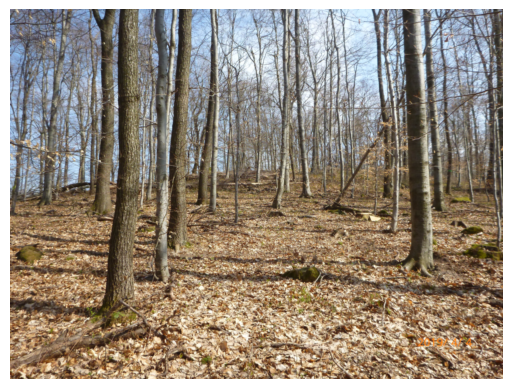

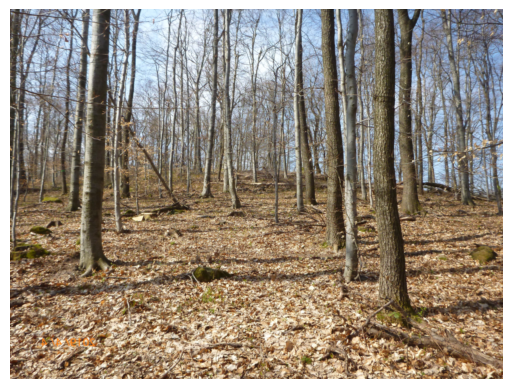

In [7]:
import matplotlib.pyplot as plt

example = x_train[0]

plt.imshow(example)
plt.axis('off')
plt.show()

example_hflip = x_train[20]

plt.imshow(example_hflip)
plt.axis('off')
plt.show()

In [13]:
factor_inc = 1.2
factor_dec = 0.8

contrast_x_train_inc = augmentor.contrast_change(x_train, factor_inc)
contrast_x_train_dec = augmentor.contrast_change(x_train, factor_dec)
print(x_train.shape)

x_train = np.concatenate([x_train, contrast_x_train_inc], axis=0)

print(x_train.shape)
x_train = np.concatenate([x_train, contrast_x_train_dec], axis=0)

y_train_cpy = y_train

y_train = np.concatenate([y_train, y_train_cpy], axis=0)
y_train = np.concatenate([y_train, y_train_cpy], axis=0)
print(x_train.shape)

#x_train, y_train = augment_dataset_with_labels(x_train, y_train)
print("Data augmented...")

x_val = x_data[split:]
y_val = y_data[split:]

flip_x_val = augmentor.horizontal_nflip(x_val)
flip_y_val = augmentor.horizontal_nflip(y_val)
print(flip_x_val.shape)

x_val = np.concatenate([x_val, flip_x_val], axis=0)
y_val = np.concatenate([y_val, flip_y_val], axis=0)
print(x_val.shape)

contrast_x_val_inc = augmentor.contrast_change(x_val, factor_inc)
contrast_x_val_dec = augmentor.contrast_change(x_val, factor_dec)
print(x_val.shape)

x_val = np.concatenate([x_val, contrast_x_val_inc], axis=0)

print(x_val.shape)
x_val = np.concatenate([x_val, contrast_x_val_dec], axis=0)

y_val_cpy = y_val

y_val = np.concatenate([y_val, y_val_cpy], axis=0)
y_val = np.concatenate([y_val, y_val_cpy], axis=0)
print(x_val.shape)

(40, 750, 1000, 3)
(80, 750, 1000, 3)
(120, 750, 1000, 3)
Data augmented...
(3, 750, 1000, 3)
(6, 750, 1000, 3)
(6, 750, 1000, 3)
(12, 750, 1000, 3)
(18, 750, 1000, 3)


In [14]:
print(y_train.shape)

(120, 750, 1000, 1)


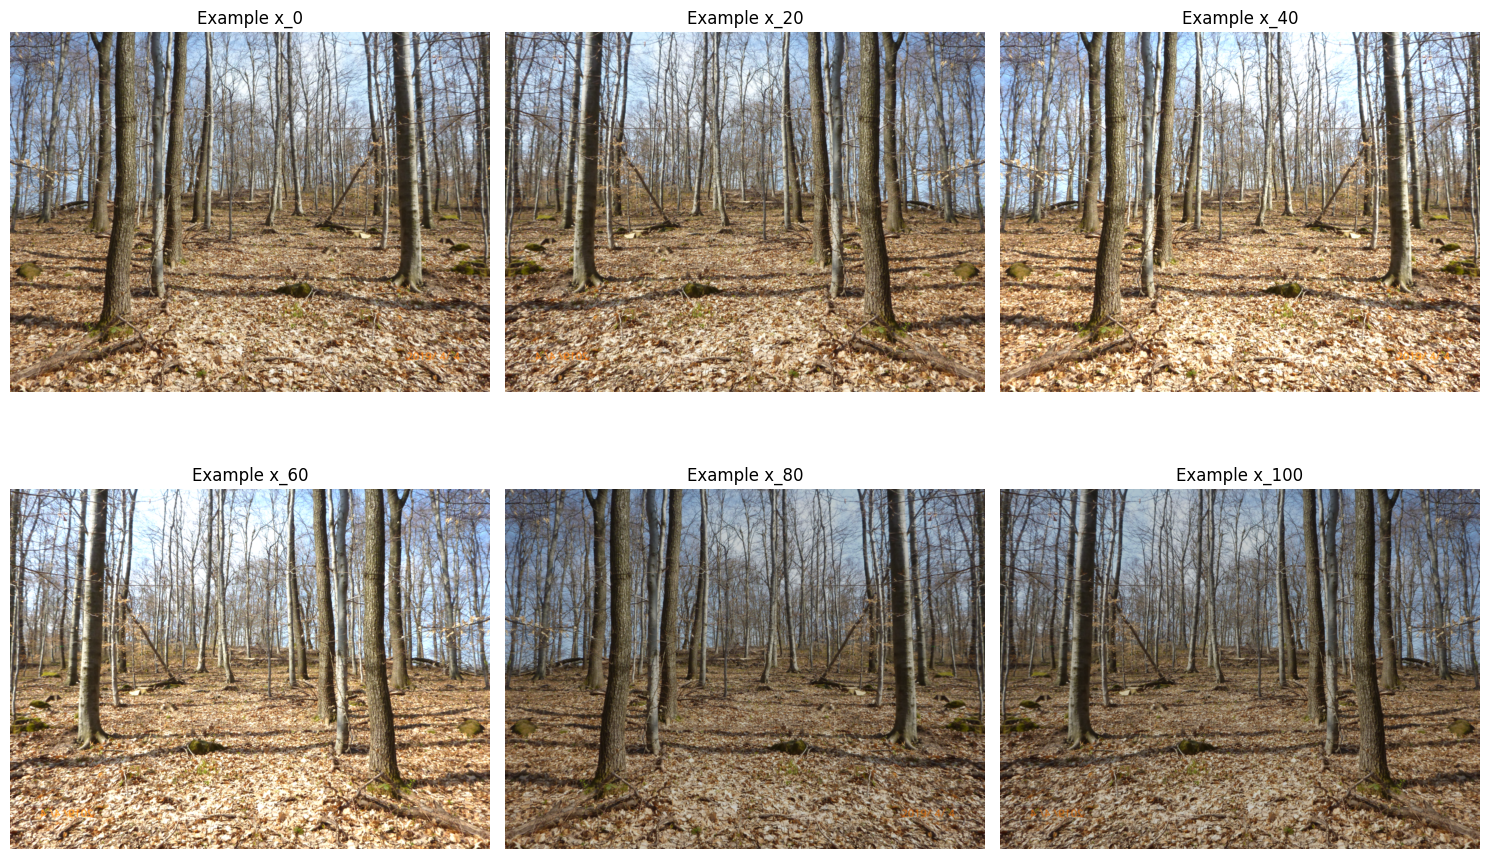

In [15]:
# Example indices
indices = [0, 20, 40, 60, 80, 100]

# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Plot each example
for i, idx in enumerate(indices):
    row = i // 3
    col = i % 3

    # Plot x examples
    axes[row, col].imshow(x_train[idx])
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Example x_{idx}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

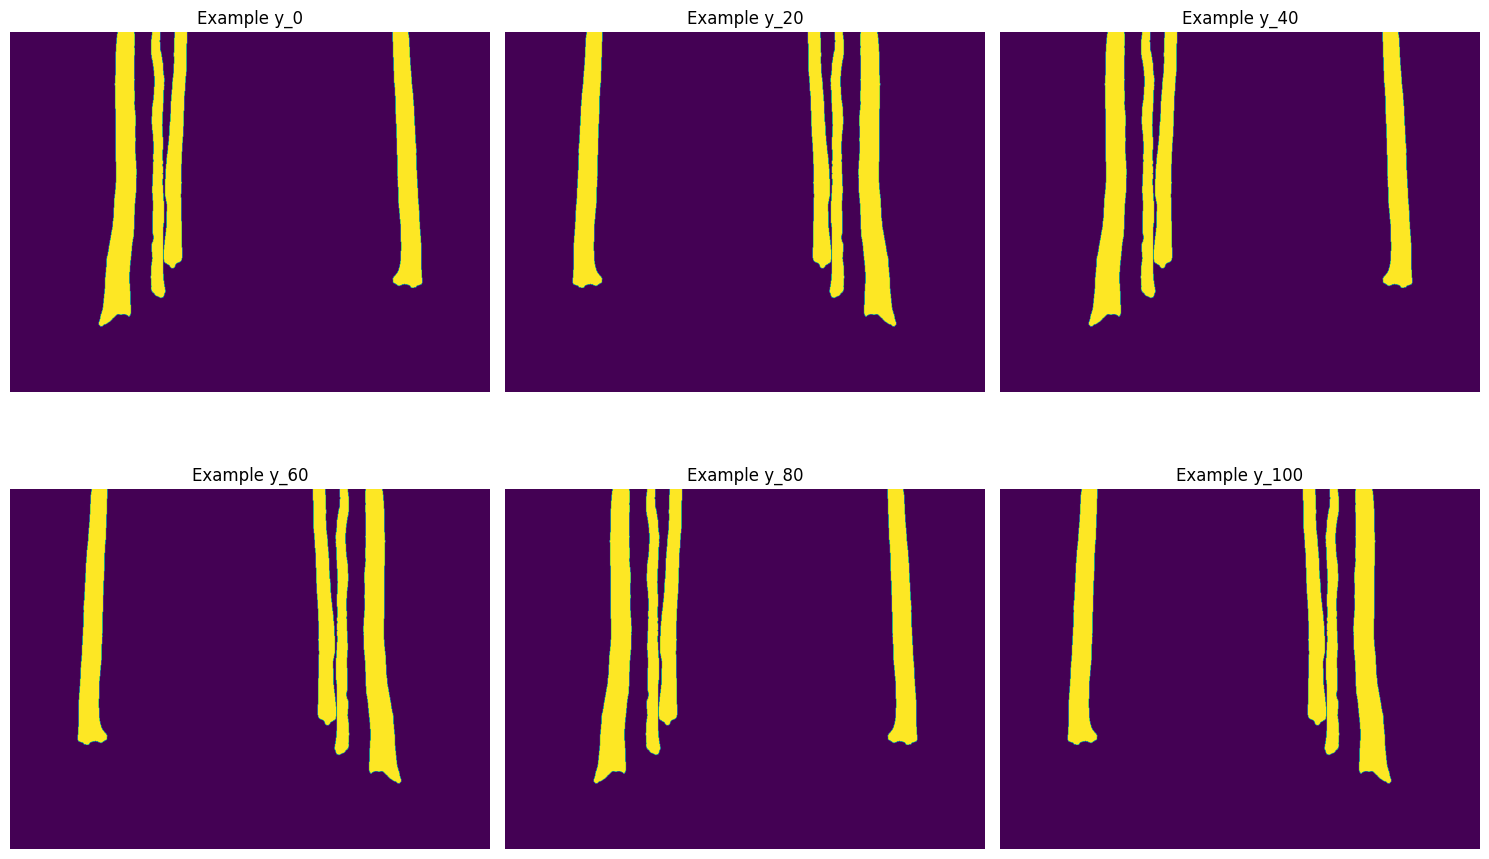

In [16]:
# Example indices
indices = [0, 20, 40, 60, 80, 100]

# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Plot each example
for i, idx in enumerate(indices):
    row = i // 3
    col = i % 3

    # Plot x examples
    axes[row, col].imshow(y_train[idx])
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Example y_{idx}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
print(x_train.shape)

(120, 750, 1000, 3)


In [18]:
colab = True
jupyter_server = False

if colab:
    #from google.colab import drive
    #drive.mount('/content/drive')
    root = '/content/tree_trunk_segmentation/data/'
    device = 'cuda'
    #!wget -O treetrunk.zip https://github.com/lacykaltgr/agriculture-image-processing/archive/refs/heads/laci420.zip
    #!unzip treetrunk.zip
    #!cp -r agriculture-image-processing-laci420/tree_trunk_segmentation/ .
    #!cp agriculture-image-processing-laci420/unet.py .
    #!cp agriculture-image-processing-laci420/utils.py .

elif jupyter_server:
    import sys
    import os
    root = ''
    device = 'cuda'
    parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
    sys.path.append(parent_directory)
else:
    import sys
    import os
    root = 'data/'
    device = 'mps'
    #parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
    #sys.path.append(parent_directory)

In [16]:
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)

print(mean.shape)

KeyboardInterrupt: ignored

In [18]:
print(y_train.shape)
print(y_train[0])

(120, 3000, 4000, 1)
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


In [19]:
#!pip install opencv-python
import cv2

In [17]:
def downsample(data):
  downsampled = list()
  for frame in data:
      d1 = cv2.pyrDown(frame)
      d2 = cv2.pyrDown(d1)
      # d3 = cv2.pyrDown(d2)
      downsampled.append(d2)
  downsampled = np.array(downsampled)
  print("Original shape: ", data.shape,
        "Downsampled shape: ", downsampled.shape)
  return downsampled

def upsample(data):
  upsampled = list()
  for frame in data:
      u1 = cv2.pyrUp(frame)
      u2 = cv2.pyrUp(u1)
      # u3 = cv2.pyrUp(u2)
      upsampled.append(u2)
  upsampled = np.array(upsampled)
  print("Original shape: ", data.shape,
        "Downsampled shape: ", upsampled.shape)
  return upsampled

Original shape:  (120, 3000, 4000, 3) Downsampled shape:  (120, 750, 1000, 3)
Original shape:  (18, 3000, 4000, 3) Downsampled shape:  (18, 750, 1000, 3)


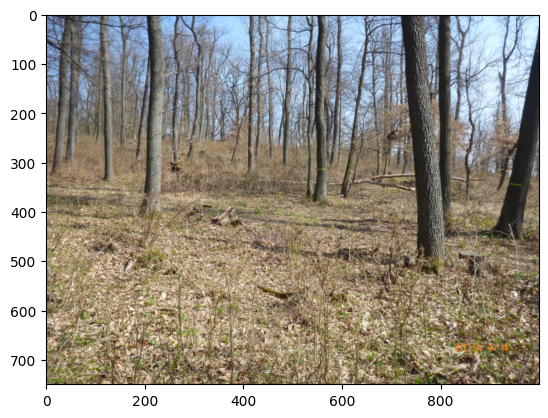

In [18]:
x_train_ds = downsample(x_train)
x_val_ds = downsample(x_val)

plt.imshow(x_train_ds[0])
plt.show()

Original shape:  (120, 3000, 4000, 1) Downsampled shape:  (120, 750, 1000)
Original shape:  (18, 3000, 4000, 1) Downsampled shape:  (18, 750, 1000)


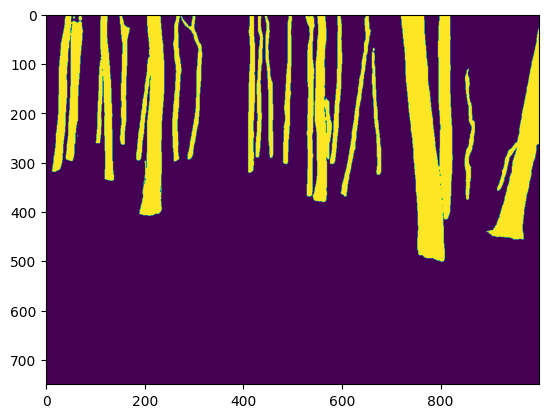

In [19]:
y_train_ds = downsample(y_train)
y_val_ds = downsample(y_val)

plt.imshow(y_train_ds[0])
plt.show()

Original shape:  (120, 750, 1000) Downsampled shape:  (120, 3000, 4000)


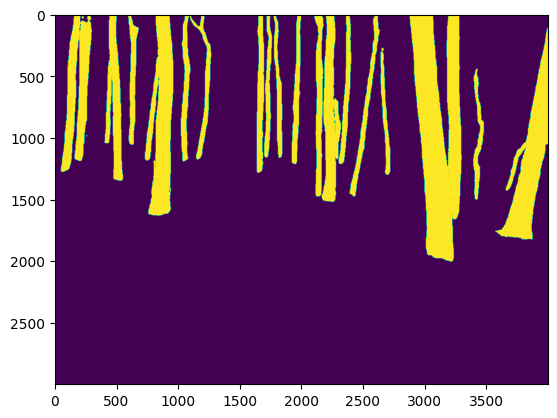

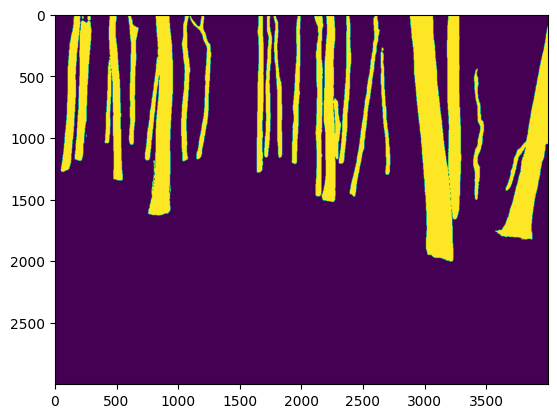

In [100]:
y_train_up = upsample(y_train_ds)

plt.imshow(y_train_up[0])
plt.show()

plt.imshow(y_train[0])
plt.show()

In [52]:
print(y_train_ds)
print(y_train_up)

np.unique(y_train_ds)
np.unique(y_train_up)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ...

KeyboardInterrupt: ignored

In [20]:
print(x_train_ds.shape)
print(y_train_ds.shape)
print(x_val_ds.shape)
print(y_val_ds.shape)

(120, 750, 1000, 3)
(120, 750, 1000)
(18, 750, 1000, 3)
(18, 750, 1000)


In [21]:
from torch.utils.data import DataLoader, Dataset

class XYDataset(Dataset):
    def __init__(self, x_data, y_data, transforms = None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transforms

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(np.transpose(self.x_data[idx]/255, [2,0,1])).float()
        #y_binary = rgb_to_binary(self.y_data[idx], color_dict)
        y = torch.tensor(np.transpose(self.y_data[idx], [2,0,1])).float()
        return x, y

#x_train, y_train, x_val, y_val, x_mean, x_std  = load_dataset(root=root, val_split_ratio=0.9)

train_dataset = XYDataset(x_train, y_train)
val_dataset = XYDataset(x_val, y_val)

print(train_dataset[0][0].shape)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

torch.Size([3, 750, 1000])


In [22]:
print(x_train[0])

[[[122 113 140]
  [126 118 145]
  [131 125 151]
  ...
  [ 97  90 100]
  [ 82  73  77]
  [ 83  72  72]]

 [[124 120 145]
  [123 119 144]
  [126 123 148]
  ...
  [ 99  95 101]
  [ 81  72  71]
  [ 77  64  61]]

 [[110 121 139]
  [112 120 139]
  [118 121 142]
  ...
  [102 101 102]
  [ 92  86  78]
  [ 89  77  69]]

 ...

 [[175 131  99]
  [164 121  88]
  [128  87  61]
  ...
  [138  99  80]
  [182 147 120]
  [197 163 127]]

 [[147 103  57]
  [159 120  66]
  [156 120  72]
  ...
  [152 117  96]
  [184 151 125]
  [224 197 157]]

 [[156 118  66]
  [178 145  85]
  [170 139  87]
  ...
  [190 169 140]
  [179 149 118]
  [208 180 143]]]


In [23]:
len(train_dataset)

120

In [51]:
import torch
from torch import nn

config = dict(
    in_channels=3,
    out_channels=1,
    hiddens=[4, 8, 16, 32],
    dropouts=[0, 0.15, 0.15, 0.15],  # hiddens
    maxpools=2,  # hiddens - 1
    kernel_sizes=3,  # 2*hiddens + 3*hiddens + 2
    paddings='same',  # 2*hiddens + 3*hiddens + 2
    strides=1,  # 2*hiddens + 3*hiddens
    criterion=nn.BCELoss(),
    output_activation=nn.Sigmoid(),
    activation=nn.ReLU(),
    dimensions=2,
    device=device
)
unet = UNet(**config).to(device)

In [26]:
from matplotlib.pyplot import imshow, show

torch.Size([3, 750, 1000])


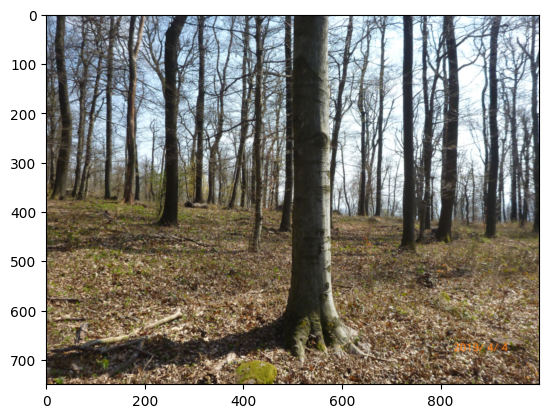

torch.Size([3, 750, 1000])


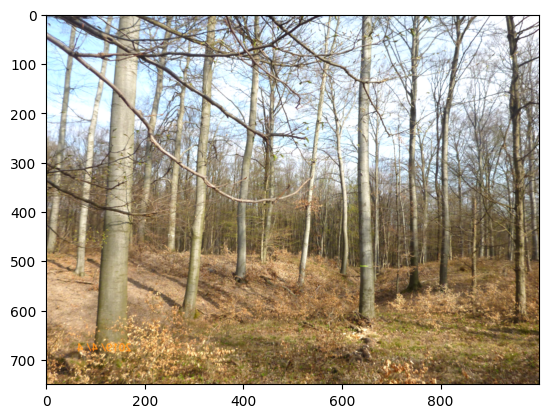

torch.Size([3, 750, 1000])


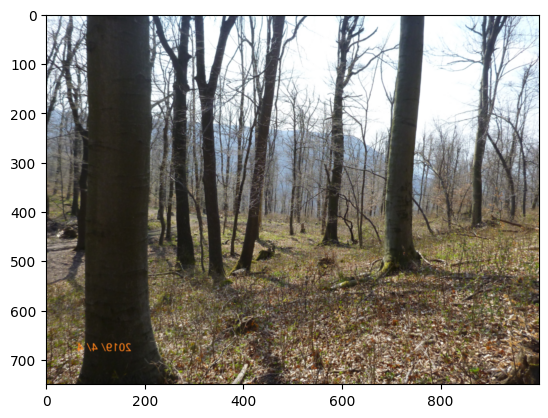

torch.Size([3, 750, 1000])


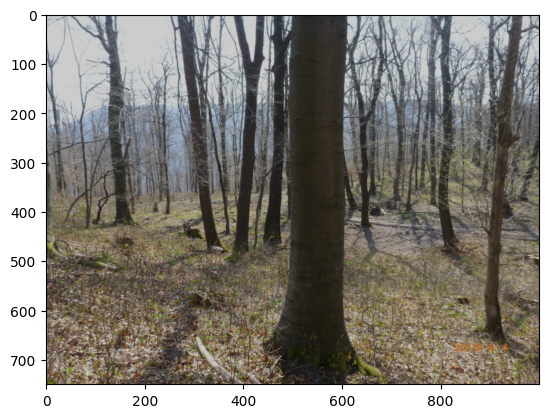

In [27]:
for valami in train_loader:
  print(valami[0][0].shape)
  imshow(np.transpose(valami[0][0].detach().cpu().numpy(), [1,2,0]))
  show()

In [ ]:
unet.summary(input_shape=(1, 3, 4000, 3000))

In [52]:
es = EarlyStopper(patience=25)
unet.train_model(train_loader, val_loader, es, num_epochs=1000, learning_rate=0.001, device=device)

Epoch 001: | Train Loss: 0.77061 | Validation Loss: 0.69184 | Train Acc: 40.96% | Valid Acc: 46.36%
Epoch 002: | Train Loss: 0.71268 | Validation Loss: 0.70700 | Train Acc: 42.93% | Valid Acc: 31.85%
Epoch 003: | Train Loss: 0.69115 | Validation Loss: 0.71037 | Train Acc: 44.93% | Valid Acc: 28.17%
Epoch 004: | Train Loss: 0.68090 | Validation Loss: 0.70710 | Train Acc: 48.17% | Valid Acc: 31.87%
Epoch 005: | Train Loss: 0.67132 | Validation Loss: 0.70182 | Train Acc: 51.03% | Valid Acc: 36.13%
Epoch 006: | Train Loss: 0.66216 | Validation Loss: 0.69876 | Train Acc: 53.21% | Valid Acc: 38.64%
Epoch 007: | Train Loss: 0.65246 | Validation Loss: 0.69523 | Train Acc: 56.16% | Valid Acc: 41.38%
Epoch 008: | Train Loss: 0.64387 | Validation Loss: 0.69253 | Train Acc: 58.61% | Valid Acc: 43.40%
Epoch 009: | Train Loss: 0.63352 | Validation Loss: 0.68700 | Train Acc: 61.05% | Valid Acc: 46.40%
Epoch 010: | Train Loss: 0.62087 | Validation Loss: 0.66404 | Train Acc: 63.75% | Valid Acc: 54.85%


([0.7706081420183182,
  0.6918368140856425,
  0.7126781344413757,
  0.7069958812660642,
  0.6911452114582062,
  0.7103685968452029,
  0.6808983087539673,
  0.7071025802029504,
  0.6713225543498993,
  0.7018203006850349,
  0.6621614694595337,
  0.6987566318776872,
  0.6524584740400314,
  0.6952315535810258,
  0.6438723504543304,
  0.6925253404511346,
  0.6335178911685944,
  0.6870026455985175,
  0.6208739578723907,
  0.664037651485867,
  0.6060846149921417,
  0.6590469943152534,
  0.5855848342180252,
  0.5880960060490502,
  0.5662713646888733,
  0.5227765490611395,
  0.5625515282154083,
  0.5086942960818609,
  0.5334588587284088,
  0.47303666671117145,
  0.5180475562810898,
  0.4556186083290312,
  0.5002745240926743,
  0.43590156733989716,
  0.48037514090538025,
  0.42804842856195235,
  0.46613970398902893,
  0.4070343358649148,
  0.45682570338249207,
  0.3753703501489427,
  0.43910545855760574,
  0.37261239025327897,
  0.42038988322019577,
  0.3578375263346566,
  0.4081868678331375,
  

In [41]:
pred = unet(val_dataset[1][0].cuda().unsqueeze(0)).detach().cpu().numpy()
bin = (pred > 0.85).astype(int)[0]

In [59]:
def eval(i):
  pred = unet(val_dataset[i][0].cuda().unsqueeze(0)).detach().cpu().numpy()
  bin = (pred > 0.5).astype(int)[0]

  from matplotlib.pyplot import show, imshow

  imshow(np.transpose(val_dataset[i][0].detach().cpu().numpy(), [1,2,0]))
  show()

  imshow(np.transpose(val_dataset[i][1].detach().cpu().numpy(), [1,2,0]))
  show()

  imshow(np.transpose(pred[0], (1,2,0)))
  show()

  imshow(np.transpose(bin, (1,2,0)))
  show()

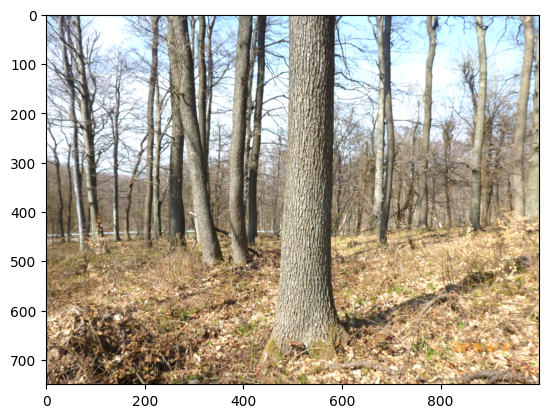

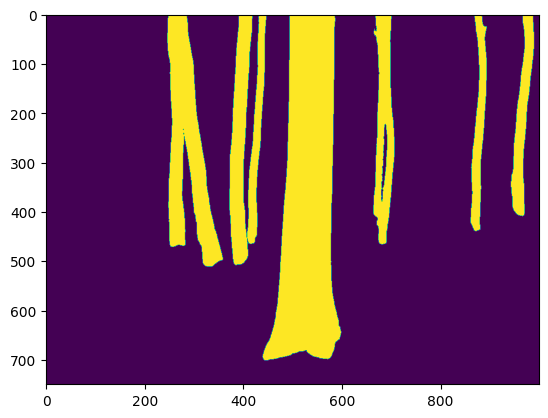

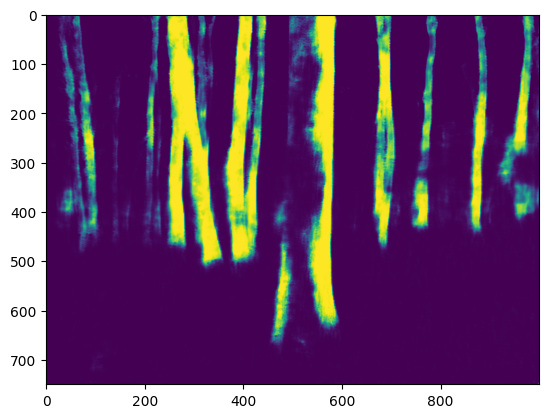

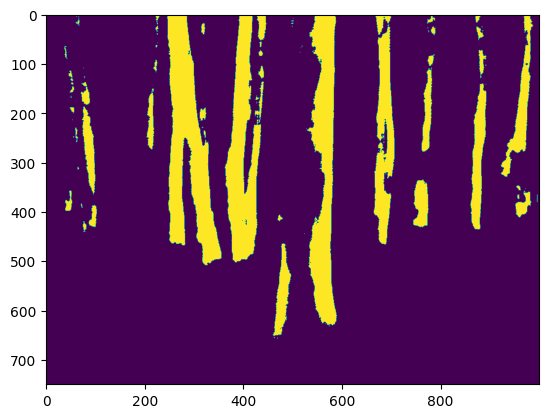

In [61]:
eval(6)

In [ ]:
predictions, results = unet.predict(val_loader, device=device)

In [63]:
# Save the model state dictionary
torch.save(unet.state_dict(), 'train1214.pth')

# Save the EarlyStopper state
earlystopper_state = {
    'patience': es.patience,
    'counter': es.counter
    # Include any other relevant information from your EarlyStopper class
}

torch.save(earlystopper_state, 'earlystopper_state.pth')

In [ ]:
unet.load_state_dict(torch.load('/Users/laszlofreund/code/ai/satellite-image-segmentation/unet.h5', map_location=device))

In [ ]:
eval = unet.evaluate(val_loader, device=device)

In [62]:
torch.save(unet, "train1214.pth")

AttributeError: ignored

In [ ]:
unet = torch.load("model.pth")

In [ ]:
unet.summary(input_shape=(1, 3, 4000, 3000))